### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import spatialdata as sd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import datetime
from copy import deepcopy
from tqdm import tqdm

from models import CNNPlusLinear
from data import get_cell_ids_in_patch, match_patch_id_to_expr, match_patch_id_to_PIL, plots_n_visualizations
from eval import compute_r2, compute_pearsonr

# hugginface
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

SEED = 209
DATA_PATH = '~/hl/ac109_project/raw'

### Data loading and processing

In [ ]:
zarr_path = osp.join(os.path.expanduser(DATA_PATH), "UC6_I.zarr/UC6_I.zarr")
sdata = sd.read_zarr(zarr_path)

In [3]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = f"log_{timestamp}.txt"
patch_id_to_cell_id = get_cell_ids_in_patch(sdata, patch_size=224, log_file=log_file)
patch_id_to_pil = match_patch_id_to_PIL(sdata, patch_id_to_cell_id, patch_size=224, log_file=log_file)
patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr = match_patch_id_to_expr(sdata, patch_id_to_cell_id, patch_id_to_pil, log_file=log_file)
plots_n_visualizations(sdata, patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr)

### Baseline: CNN + Linear Regression

In [4]:
# process images, pair with expression vectors
transform = transforms.ToTensor()

# split data into train and validation sets
patch_list = list(patch_id_to_pil.values())
expr_list = list(patch_id_to_expr.values())
patch_train, patch_val, expr_train, expr_val = train_test_split(
    patch_list, expr_list, test_size=0.2, random_state=SEED, shuffle=True
)

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]

# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0304, Val Loss: 0.0274, R2: 0.3655, Pearson: 0.6152
Epoch 2/100, Train Loss: 0.0247, Val Loss: 0.0250, R2: 0.4351, Pearson: 0.6733
Epoch 3/100, Train Loss: 0.0225, Val Loss: 0.0236, R2: 0.4757, Pearson: 0.6961
Epoch 4/100, Train Loss: 0.0217, Val Loss: 0.0231, R2: 0.4923, Pearson: 0.7056
Epoch 5/100, Train Loss: 0.0214, Val Loss: 0.0228, R2: 0.5005, Pearson: 0.7110
Epoch 6/100, Train Loss: 0.0212, Val Loss: 0.0231, R2: 0.4904, Pearson: 0.7071
Epoch 7/100, Train Loss: 0.0210, Val Loss: 0.0229, R2: 0.4953, Pearson: 0.7098
Epoch 8/100, Train Loss: 0.0209, Val Loss: 0.0227, R2: 0.5008, Pearson: 0.7138
Epoch 9/100, Train Loss: 0.0207, Val Loss: 0.0224, R2: 0.5108, Pearson: 0.7198
Epoch 10/100, Train Loss: 0.0206, Val Loss: 0.0222, R2: 0.5170, Pearson: 0.7237
Epoch 11/100, Train Loss: 0.0204, Val Loss: 0.0221, R2: 0.5214, Pearson: 0.7268
Epoch 12/100, Train Loss: 0.0203, Val Loss: 0.0219, R2: 0.5271, Pearson: 0.7306
Epoch 13/100, Train Loss: 0.0201, Val Loss: 0.021

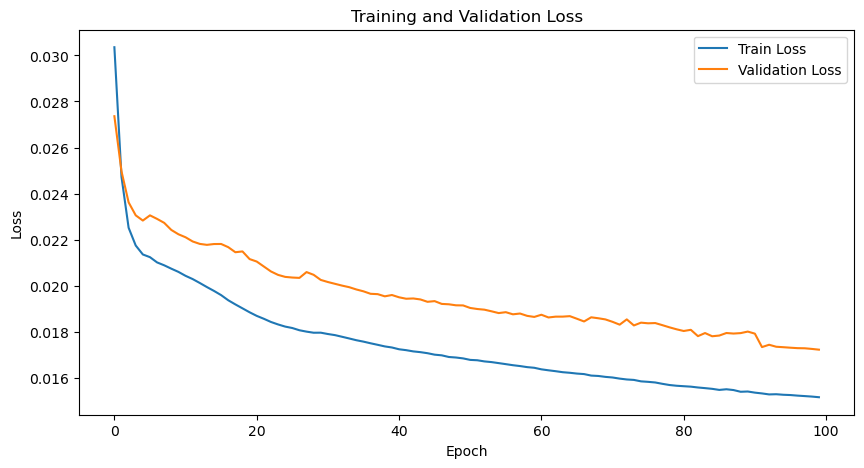

In [5]:
# train the model
model = CNNPlusLinear().to('cuda')

# configs
n_epoch = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()

# early stopping
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses, val_losses = [], []
r2_scores, pearson_scores = [], []

for epoch in range(n_epoch):
    # train
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # validate
    model.eval()
    running_val_loss = 0.0
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            running_val_loss += loss.item()

            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    # metrics
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    r2_scores.append(r2_score)
    pearson_scores.append(pearson_score)

    # log and es
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored.")

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

### Using UNI to Extract Features

In [6]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [7]:
# split data into train and validation sets
patch_list = list(patch_id_to_pil.values())
expr_list = list(patch_id_to_expr.values())
patch_train, patch_val, expr_train, expr_val = train_test_split(
    patch_list, expr_list, test_size=0.2, random_state=SEED, shuffle=True
)

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0249, Val Loss: 0.0183, R2: 0.6217, Pearson: 0.7933
Epoch 2/100, Train Loss: 0.0179, Val Loss: 0.0168, R2: 0.6575, Pearson: 0.8150
Epoch 3/100, Train Loss: 0.0163, Val Loss: 0.0162, R2: 0.6713, Pearson: 0.8220
Epoch 4/100, Train Loss: 0.0153, Val Loss: 0.0156, R2: 0.6876, Pearson: 0.8302
Epoch 5/100, Train Loss: 0.0148, Val Loss: 0.0156, R2: 0.6849, Pearson: 0.8279
Epoch 6/100, Train Loss: 0.0144, Val Loss: 0.0157, R2: 0.6891, Pearson: 0.8298
Epoch 7/100, Train Loss: 0.0141, Val Loss: 0.0151, R2: 0.6963, Pearson: 0.8324
Epoch 8/100, Train Loss: 0.0138, Val Loss: 0.0153, R2: 0.6941, Pearson: 0.8320
Epoch 9/100, Train Loss: 0.0137, Val Loss: 0.0152, R2: 0.6975, Pearson: 0.8336
Epoch 10/100, Train Loss: 0.0134, Val Loss: 0.0154, R2: 0.6923, Pearson: 0.8334
Epoch 11/100, Train Loss: 0.0135, Val Loss: 0.0153, R2: 0.6972, Pearson: 0.8337
Epoch 12/100, Train Loss: 0.0130, Val Loss: 0.0154, R2: 0.6966, Pearson: 0.8340
Epoch 13/100, Train Loss: 0.0128, Val Loss: 0.015

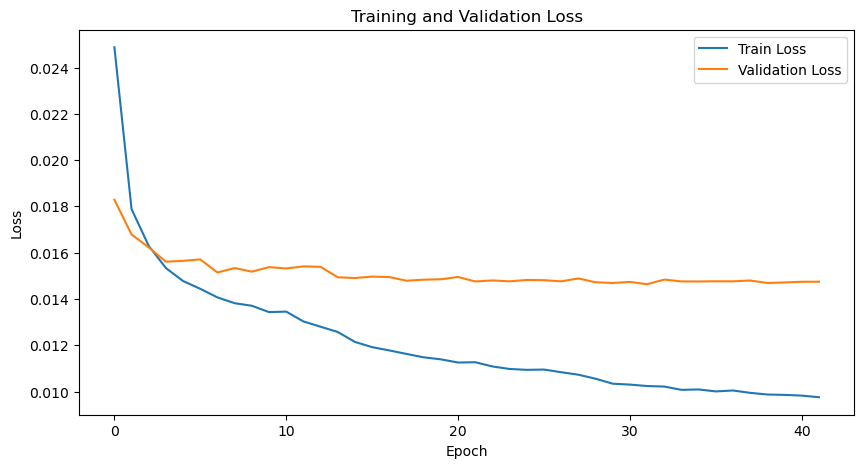

In [8]:
# train the model
model = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

# configs
n_epoch = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()

# early stopping
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses, val_losses = [], []
r2_scores, pearson_scores = [], []

for epoch in range(n_epoch):
    # train
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # validate
    model.eval()
    running_val_loss = 0.0
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            running_val_loss += loss.item()

            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    # metrics
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    r2_scores.append(r2_score)
    pearson_scores.append(pearson_score)

    # log and es
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored.")

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()